# Singular Vector Transformation

## Overview

The singular vector transformation implements a matraix that transforms the right singular vector to the corresponding left singular vector. Suppose that we have access to a unitary $U$, its inverse $U^\dagger$ and the controlled reflection operators $(2\Pi - I)$, $(2\tilde{\Pi}-I)$, just as in the singular value threshold projector example. Our matrix of interest is $A := \tilde{\Pi}U\Pi$ with singular value decomposition $A = \sum_k \sigma_k |\phi_k \rangle \langle \psi_k$. The singular vector transformation algorithm performs the transformation
$$ \sum_k \alpha_k |\psi_k \rangle \mapsto \sum_k \alpha_k |\phi_k \rangle. $$
This algorithm can be used for devising a new method for singular value estimation. It also has many applications, e.g. efficient ground state preparation of certain local Hamiltonians.

As shown in the proof of Theorem 1 in [GSLW], this algorithm aims to apply the sign function $f$ to the singular values of $A$. In practice, we can find an odd polynomial approximation to $f$, denoted as $f_{\text{poly}}$, on the interval $D_\kappa = [-1,-\delta]\cup [\delta, 1]$. By applying $f_{\text{poly}}$ instead of $f$, this algorithm maps the right singular vector with singular value at least $\delta$ to the corresponding left singular vector.

## Polynomial approximation

For numerical demonstration, we scale the target function by a factor of 0.8 to improve numerical stability. We can again call our subroutine to find the best odd polynomial approximating $f(x)$ on the interval $D_\kappa$, solving the problem by convex optimization.

norm error = 2.1228236946058132e-09
max of solution = 0.8000006369361398


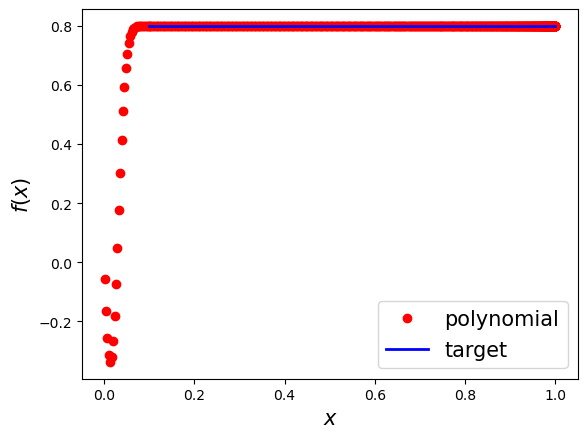

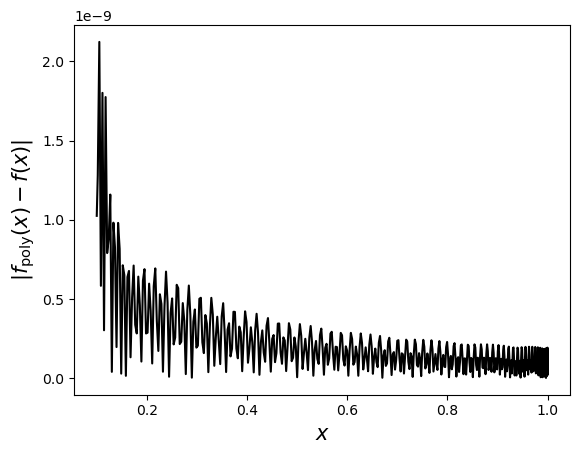

In [1]:
import numpy as np
from optimization.utils import cvx_poly_coef

delta = 0.1
targ = lambda x: 0.8 * np.sign(x)
deg = 251
parity = deg % 2

opts = {
    'intervals': [delta, 1],
    'objnorm': np.inf,
    'epsil': 0.1,
    'npts': 500,
    'isplot': True,
    'fscale': 1,
    'method': 'cvxpy'
}

coef_full = cvx_poly_coef(targ, deg, opts)
coef = coef_full[parity::2]

## Solving the phase factors and verifying

We can again use Newton's method to find the phase factors and verify the solution.

iter err          
   1  +4.2964e-01
   2  +5.9888e-02
   3  +1.8712e-03
   4  +1.9232e-06
   5  +1.9158e-12
Stop criteria satisfied.
The residual error is
1.8762769116165146e-14


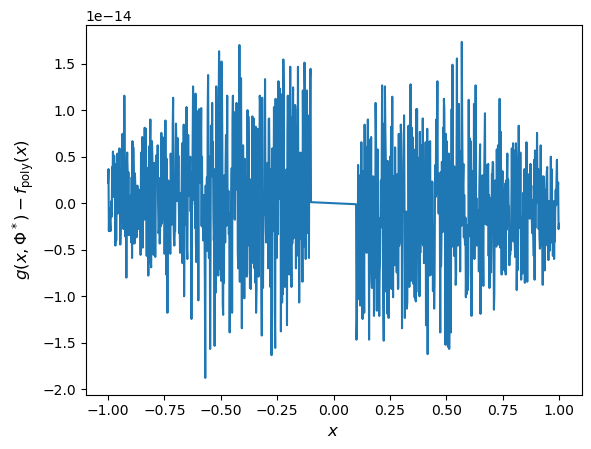

In [2]:
opts.update({
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': False,
    'targetPre': True,
    'method': 'Newton'
})

from optimization.QSP_solver import solve
phi_proc, out = solve(coef, parity, opts)

from optimization.utils import chebyshev_to_func
from optimization.core import get_entry
import matplotlib.pyplot as plt

xlist1 = np.linspace(-1,-delta,500)
xlist2 = np.linspace(delta,1,500)
xlist = np.concatenate([xlist1, xlist2])
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).

2. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.